In [59]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, f1_score


In [60]:
# Load Dataset
path = r"D:\binary-classification-mlops\data\raw\cereal.csv"
df = pd.read_csv(path)

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (77, 16)


,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


In [61]:
# Clean cereal names
def clean_cereal_name(name: str) -> str:
    if not isinstance(name, str): return name
    name = name.lower().strip().replace("-", " ")
    name = re.sub(r"[^a-z0-9\s]", "", name)
    return re.sub(r"\s+", " ", name)

df["name"] = df["name"].apply(clean_cereal_name)

In [62]:
# Handle Negative Outliers in Numerical Columns
num_cols = ["calories","protein","fat","sodium","fiber","carbo","sugars","potass","vitamins","weight","cups"]
df[num_cols] = df[num_cols].mask(df[num_cols] < 0, np.nan)

print("Missing values after cleaning:", df.isnull().sum().sum())

Missing values after cleaning: 4


In [63]:
# Define Target Variable (Feature Engineering)
def health_class(row):
    if row["fiber"] >= 7 and row["sugars"] <= 5 and row["calories"] <= 110:
        return 2   # Healthy
    elif row["fiber"] >= 3 and row["sugars"] <= 10:
        return 1   # Moderately healthy
    else:
        return 0   # Unhealthy

df["target"] = df.apply(health_class, axis=1)

In [64]:
print("Target distribution:\n", df["target"].value_counts())

Target distribution:
 target
0    57
1    18
2     2
Name: count, dtype: int64


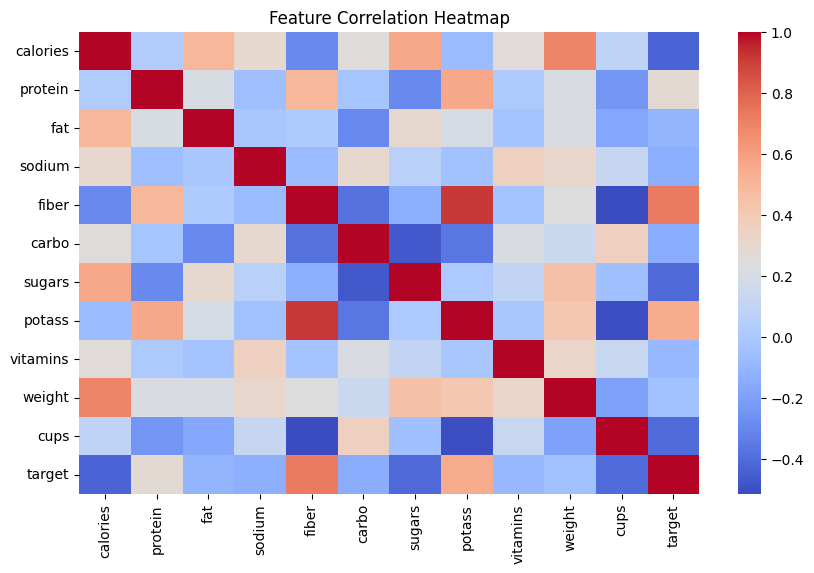

In [65]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[num_cols + ["target"]].corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [66]:
LEAKAGE_COLS = ["fiber", "sugars", "calories"]   # used to build target
DROP_COLS = ["name", "rating"] + LEAKAGE_COLS
DROP_COLS = [c for c in DROP_COLS if c in df.columns]

df_model = df.drop(columns=DROP_COLS)

In [67]:
X = df_model.drop(columns=["target"])
y = df_model["target"]

In [68]:
X.shape

(77, 11)

In [69]:
y.shape

(77,)

In [70]:
cat_features = [c for c in ["mfr", "type", "shelf"] if c in X.columns]
num_features = [c for c in X.columns if c not in cat_features]

print("Categorical:", cat_features)
print("Numerical:", num_features)

Categorical: ['mfr', 'type', 'shelf']
Numerical: ['protein', 'fat', 'sodium', 'carbo', 'potass', 'vitamins', 'weight', 'cups']


In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 61
Testing set size: 16


In [72]:
print("\nOverall classes:\n", y.value_counts())
print("\nTrain classes:\n", y_train.value_counts())
print("\nTest classes:\n", y_test.value_counts())


Overall classes:
 target
0    57
1    18
2     2
Name: count, dtype: int64

Train classes:
 target
0    45
1    14
2     2
Name: count, dtype: int64

Test classes:
 target
0    12
1     4
Name: count, dtype: int64


In [73]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [74]:
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features)
])


In [75]:
def evaluate_holdout(pipe, model_name):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print(f"\n==================== {model_name} (HOLDOUT TEST) ====================")
    print(classification_report(y_test, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("F1 Macro:", f1_score(y_test, y_pred, average="macro"))
    print("F1 Weighted:", f1_score(y_test, y_pred, average="weighted"))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

def evaluate_cv(pipe, model_name):
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1_macro", n_jobs=-1)
    print(f"\n{model_name} CV F1 Macro: mean={scores.mean():.4f}, std={scores.std():.4f}")
    return scores.mean()


LogisticRegression CV F1 Macro: mean=0.5328, std=0.1442

==================== LogisticRegression (HOLDOUT TEST) ====================
              precision    recall  f1-score   support

           0       1.00      0.58      0.74        12
           1       0.44      1.00      0.62         4

    accuracy                           0.69        16
   macro avg       0.72      0.79      0.68        16
weighted avg       0.86      0.69      0.71        16

Balanced Accuracy: 0.7916666666666667
F1 Macro: 0.6761133603238867
F1 Weighted: 0.7064777327935222


d:\binary-classification-mlops\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


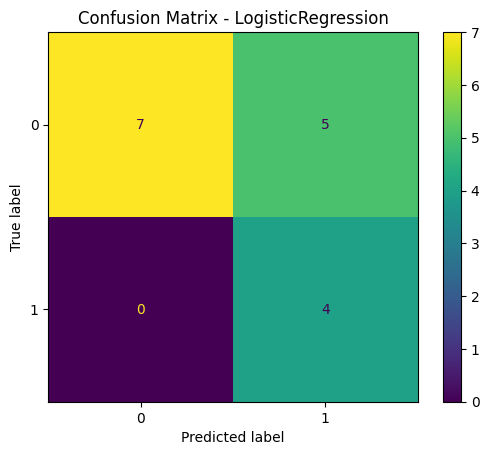

In [76]:
from sklearn.linear_model import LogisticRegression

logreg_pipe = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

logreg_cv = evaluate_cv(logreg_pipe, "LogisticRegression")
evaluate_holdout(logreg_pipe, "LogisticRegression")

d:\binary-classification-mlops\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



SVM_RBF CV F1 Macro: mean=0.5589, std=0.1425

==================== SVM_RBF (HOLDOUT TEST) ====================
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.50      1.00      0.67         4

    accuracy                           0.75        16
   macro avg       0.75      0.83      0.73        16
weighted avg       0.88      0.75      0.77        16

Balanced Accuracy: 0.8333333333333333
F1 Macro: 0.7333333333333334
F1 Weighted: 0.7666666666666667


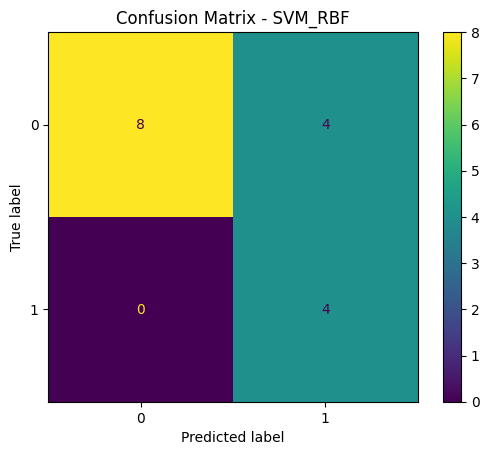

In [77]:
from sklearn.svm import SVC

svm_pipe = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", SVC(kernel="rbf", class_weight="balanced"))
])

svm_cv = evaluate_cv(svm_pipe, "SVM_RBF")
evaluate_holdout(svm_pipe, "SVM_RBF")

d:\binary-classification-mlops\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



RandomForest CV F1 Macro: mean=0.4746, std=0.0659

==================== RandomForest (HOLDOUT TEST) ====================
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.60      0.75      0.67         4

    accuracy                           0.81        16
   macro avg       0.75      0.79      0.77        16
weighted avg       0.83      0.81      0.82        16

Balanced Accuracy: 0.7916666666666667
F1 Macro: 0.7681159420289855
F1 Weighted: 0.8188405797101449


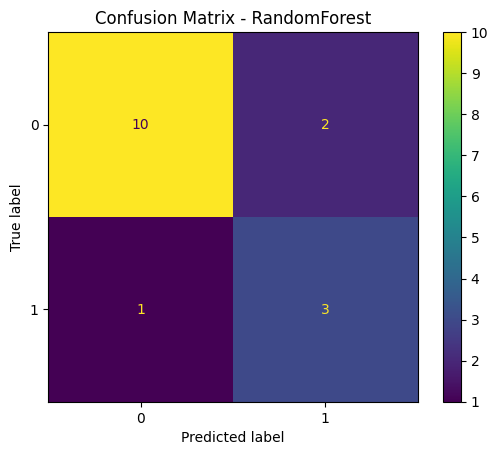

In [78]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_estimators=400
    ))
])

rf_cv = evaluate_cv(rf_pipe, "RandomForest")
evaluate_holdout(rf_pipe, "RandomForest")

d:\binary-classification-mlops\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



XGBoost CV F1 Macro: mean=0.4479, std=0.1202

==================== XGBoost (HOLDOUT TEST) ====================
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.50      0.75      0.60         4

    accuracy                           0.75        16
   macro avg       0.70      0.75      0.71        16
weighted avg       0.80      0.75      0.76        16

Balanced Accuracy: 0.75
F1 Macro: 0.7090909090909091
F1 Weighted: 0.7636363636363637


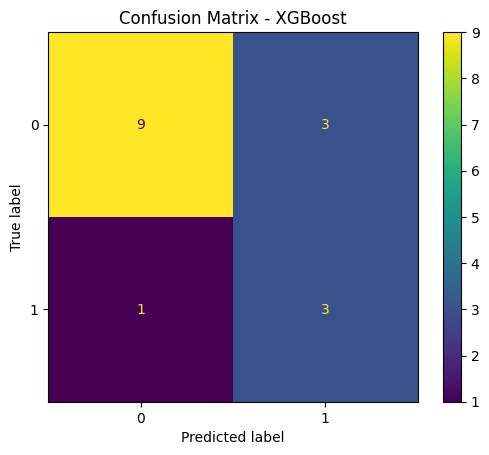

In [79]:
from xgboost import XGBClassifier

n_classes = y_train.nunique()

if n_classes <= 2:
    xgb_clf = XGBClassifier(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        reg_alpha=0.0,
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=42
    )
else:
    xgb_clf = XGBClassifier(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        reg_alpha=0.0,
        objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42
    )

xgb_pipe = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", xgb_clf)
])

xgb_cv = evaluate_cv(xgb_pipe, "XGBoost")
evaluate_holdout(xgb_pipe, "XGBoost")


In [80]:
results = pd.DataFrame([
    {"model": "LogisticRegression", "cv_f1_macro": logreg_cv},
    {"model": "SVM_RBF", "cv_f1_macro": svm_cv},
    {"model": "RandomForest", "cv_f1_macro": rf_cv},
    {"model": "XGBoost", "cv_f1_macro": xgb_cv},
]).sort_values("cv_f1_macro", ascending=False)

print("\n=== FINAL CV COMPARISON ===")
print(results.to_string(index=False))



=== FINAL CV COMPARISON ===
             model  cv_f1_macro
           SVM_RBF     0.558915
LogisticRegression     0.532778
      RandomForest     0.474586
           XGBoost     0.447924


In [81]:
import optuna
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

def svm_objective(trial):
    C = trial.suggest_float("C", 1e-3, 100.0, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 10.0, log=True)

    clf = SVC(
        kernel="rbf",
        C=C,
        gamma=gamma,
        class_weight="balanced"
    )

    pipe = Pipeline([
        ("pre", preprocessor),
        ("clf", clf)
    ])

    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1
    )
    return scores.mean()

study_svm = optuna.create_study(direction="maximize")
study_svm.optimize(svm_objective, n_trials=30)

print("Best SVM params:", study_svm.best_params)
print("Best CV F1 Macro:", study_svm.best_value)


[I 2026-01-05 18:14:19,919] A new study created in memory with name: no-name-8d0b891c-7c75-44cd-b038-bd3fd888b53e
d:\binary-classification-mlops\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
[I 2026-01-05 18:14:19,947] Trial 0 finished with value: 0.4064239028944911 and parameters: {'C': 1.6348709672172825, 'gamma': 0.33893823398043776}. Best is trial 0 with value: 0.4064239028944911.
d:\binary-classification-mlops\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
[I 2026-01-05 18:14:19,973] Trial 1 finished with value: 0.36883116883116884 and parameters: {'C': 20.285343002169387, 'gamma': 6.301406951482294}. Best is trial 0 with value: 0.4064239028944911.
d:\binary-classification-mlops\.venv\Lib\site-packages\sklearn\model_selection\_s

Best SVM params: {'C': 89.97760808802025, 'gamma': 0.00010122831232071927}
Best CV F1 Macro: 0.6232570806100217



==================== SVM_RBF_TUNED (HOLDOUT TEST) ====================
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.40      0.50      0.44         4

    accuracy                           0.69        16
   macro avg       0.61      0.62      0.61        16
weighted avg       0.71      0.69      0.70        16

Balanced Accuracy: 0.625
F1 Macro: 0.6135265700483092
F1 Weighted: 0.6980676328502415


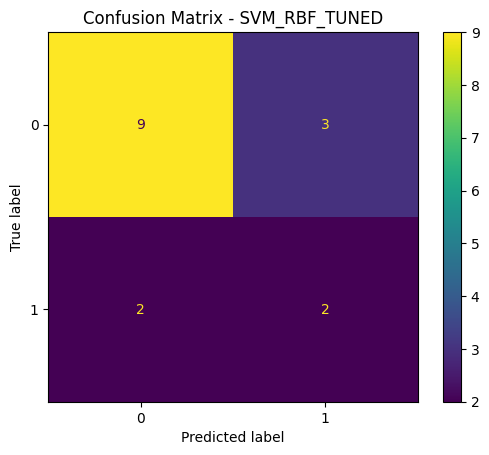

In [82]:
best_svm = SVC(
    kernel="rbf",
    class_weight="balanced",
    **study_svm.best_params
)

best_svm_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", best_svm)
])

evaluate_holdout(best_svm_pipe, "SVM_RBF_TUNED")



Baseline SVM CV: 0.5589153439153439
Tuned SVM CV: 0.6232570806100217

==================== FINAL_SVM_TUNED (HOLDOUT TEST) ====================
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.40      0.50      0.44         4

    accuracy                           0.69        16
   macro avg       0.61      0.62      0.61        16
weighted avg       0.71      0.69      0.70        16

Balanced Accuracy: 0.625
F1 Macro: 0.6135265700483092
F1 Weighted: 0.6980676328502415


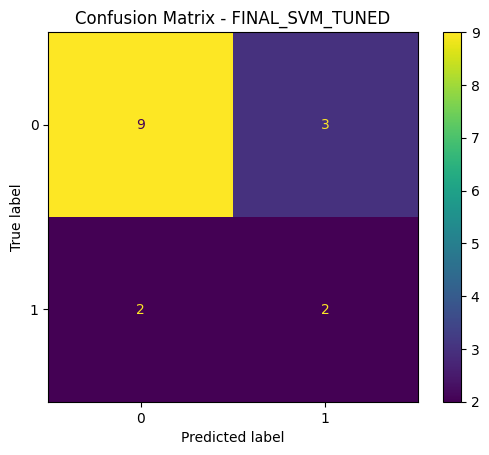

In [83]:
print("\nBaseline SVM CV:", svm_cv)
print("Tuned SVM CV:", study_svm.best_value)

final_pipe = svm_pipe if study_svm.best_value <= svm_cv else best_svm_pipe
final_name = "FINAL_SVM_BASELINE" if final_pipe is svm_pipe else "FINAL_SVM_TUNED"

evaluate_holdout(final_pipe, final_name)